In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 12 10:42:13 2018

GAN IP: General Adaptive Neighborhood Image Processing

@author: yann
"""
import numpy as np
import skimage.morphology
import skimage.io
import skimage.measure
import matplotlib.pyplot as plt
import scipy.ndimage.filters


def imsave(filename, A):
    """
    save image A in filename
    performs histogram stretching
    """
    if np.min(A) < 0:
        print("error: negative values")
    skimage.io.imsave(filename, A.astype('uint8'))


def GAN(A, p, m):
    """
    GAN construction 
    A: grayscale image
    p: point
    m: tolerance
    """
    RES = np.zeros(A.shape)
    RES[p[0], p[1]] = 1
    s = A[p[0], p[1]]
    thresh = np.logical_and(A >= s-m, A <= s+m)
    SE = np.ones((3, 3))
    RES = skimage.morphology.reconstruction(RES, thresh, selem=SE)
    return RES


def GANmean(A, m):
    """
    GAN mean filter
    Apply mean value of the adaptive neighborhood to result
    A: original image
    m: tolerance
    return: GAN mean filter
    """
    RES = np.zeros(A.shape).astype('float')
    SE = np.ones((3, 3))
    for s in np.arange(256):
        thresh = np.logical_and(A >= s-m, A <= s+m)
        seed = A == s
        thresh = skimage.morphology.reconstruction(seed, thresh, selem=SE)
        L, n = skimage.measure.label(thresh, connectivity=2, return_num=True)
        for l in np.arange(1, n+1):
            currentLabel = L == l
            values = A[currentLabel]
            meanValues = np.mean(values)
            result = meanValues * \
                np.logical_and(seed, currentLabel).astype('float')
            RES = RES + result
    return RES


def GANdilation(A, criterion, m):
    """
    GAN dilation
    A: original image
    criterion: criterion image
    m: tolerance
    return: dilation
    """
    RES = np.zeros(A.shape).astype('float')
    SE = np.ones((3, 3))
    for s in np.arange(256):
        thresh = np.logical_and(criterion >= s-m, criterion <= s+m)
        seed = criterion == s
        thresh = skimage.morphology.reconstruction(seed, thresh, selem=SE)
        L, n = skimage.measure.label(thresh, connectivity=2, return_num=True)
        for l in np.arange(1, n+1):
            currentLabel = L == l
            values = A[currentLabel]
            values.sort()
            result = currentLabel.astype('float') * values[-1]
            RES = np.maximum(RES, result)
    return RES


def GANerosion(A, criterion, m):
    """
    GAN erosion
    A: original image
    criterion: criterion image
    m: tolerance
    return: erosion
    """
    RES = 255 * np.ones(A.shape).astype('float')
    SE = np.ones((3, 3))
    for s in np.arange(256):
        thresh = np.logical_and(criterion >= s-m, criterion <= s+m)
        seed = criterion == s
        thresh = skimage.morphology.reconstruction(seed, thresh, selem=SE)
        L, n = skimage.measure.label(thresh, connectivity=2, return_num=True)
        for l in np.arange(1, n+1):
            currentLabel = L == l
            values = A[currentLabel]
            values.sort()
            result = currentLabel.astype(
                'float') * values[0] + 255*np.logical_not(currentLabel.astype('float'))
            RES = np.minimum(RES, result)
    return RES


def GANopening(A, criterion, m):
    """   
    GAN opening
    A: original image
    criterion: criterion image
    m: tolerance
    return: opening
    """
    temp = GANerosion(A, criterion, m)
    RES = GANdilation(temp, criterion, m)
    return RES


def GANclosing(A, criterion, m):
    """    
    GAN closing
    A: original image
    criterion: criterion image
    m: tolerance
    return: closing
    """
    temp = GANdilation(A, criterion, m)
    RES = GANerosion(temp, criterion, m)
    return RES


# %% Display neighborhood for some tolerance values
I = skimage.io.imread('lena.png')
p = [100, 200]
for m in 5, 50, 75:
    RES = GAN(I, p, m)
    plt.imshow(RES, cmap='gray')
    plt.show()
    imsave('GAN'+str(m) + '.python.png', 255*RES)


# %% GAN Choquet filtering: mean
B = scipy.ndimage.filters.uniform_filter(I, size=5)
imsave('lena_classicalMean.python.png', B)
m = 30
C = GANmean(I, m)
imsave('lena_GANMean.python.png', C)
plt.subplot(131)
plt.axis('off')
plt.imshow(I, cmap='gray')
plt.title('Original image')
plt.subplot(132)
plt.axis('off')
plt.imshow(C, cmap='gray')
plt.title('GAN mean')
plt.subplot(133)
plt.axis('off')
plt.imshow(B, cmap='gray')
plt.title('Classical mean')
plt.show()


######################
# GAN morphological filtering
# %% erosion/dilation
plt.figure()
ind = 231
plt.subplot(ind)
plt.axis('off')
plt.imshow(I, cmap='gray')
plt.title('Original image')

Cdil = GANdilation(I, I, m)
imsave('lena_GANDilation.python.png', Cdil)
plt.subplot(ind+1)
plt.axis('off')
plt.imshow(Cdil, cmap='gray')
plt.title('GAN dilation')

Cero = GANerosion(I, I, m)
imsave('lena_GANErosion.python.png', Cero)
plt.subplot(ind+2)
plt.axis('off')
plt.imshow(Cero, cmap='gray')
plt.title('GAN erosion')

# classical morphology: erosion, dilation
se = skimage.morphology.disk(2)
Bdil = skimage.morphology.dilation(I, selem=se)
Bero = skimage.morphology.erosion(I, selem=se)
imsave('lena_classicalDilation.python.png', Bdil)
imsave('lena_classicalErosion.python.png', Bero)
plt.subplot(ind+4)
plt.axis('off')
plt.imshow(Bdil, cmap='gray')
plt.title('Classical dilation')
plt.subplot(ind+5)
plt.axis('off')
plt.imshow(Bero, cmap='gray')
plt.title('Classical erosion')
plt.show()

######################
# %% open close
plt.figure()
ind = 231
plt.subplot(ind)
plt.axis('off')
plt.imshow(I, cmap='gray')
plt.title('Original image')

Copen = GANopening(I, I, m)
Cclose = GANclosing(I, I, m)
imsave('lena_GANOpening.python.png', Copen)
imsave('lena_GANClosing.python.png', Cclose)

plt.subplot(ind+1)
plt.axis('off')
plt.imshow(Copen, cmap='gray')
plt.title('GAN opening')
plt.subplot(ind+2)
plt.axis('off')
plt.imshow(Cclose, cmap='gray')
plt.title('GAN closing')
plt.show()

# classical open close
Bopen = skimage.morphology.opening(I, selem=se)
Bclose = skimage.morphology.closing(I, selem=se)

imsave('lena_classicalOpening.python.png', Bopen)
imsave('lena_classicalClosing.python.png', Bclose)
plt.subplot(ind+4)
plt.axis('off')
plt.imshow(Bopen, cmap='gray')
plt.title('Classical opening')
plt.subplot(ind+5)
plt.axis('off')
plt.imshow(Bclose, cmap='gray')
plt.title('Classical closing')

plt.show()

###########################
# %% check idempotence

# second application of opening is equal to first
Copen2 = GANopening(Copen, I, m)
Cclose2 = GANclosing(Cclose, I, m)
if np.max(np.abs(Copen2-Copen)) == 0:
    print("OK: idempotence in opening")
else:
    print("error in opening")
if np.max(np.abs(Cclose2-Cclose)) == 0:
    print("OK: idempotence in closing")
else:
    print("error in opening")
###########################
# %% check extensivity and anti-extensivity
if np.all(Copen <= I):
    print("OK: extensivity")
else:
    print("error in extensivity")

if np.all(Cclose >= I):
    print("OK: anti-extensivity")
else:
    print("error in anti-extensivity")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 3 Axes>

<Figure size 640x480 with 5 Axes>

<Figure size 640x480 with 5 Axes>

OK: idempotence in opening
OK: idempotence in closing
OK: extensivity
OK: anti-extensivity


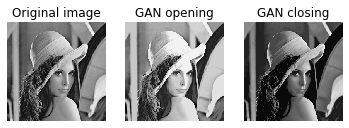

In [2]:
plt.figure()
ind = 231
plt.subplot(ind)
plt.axis('off')
plt.imshow(I, cmap='gray')
plt.title('Original image')

Copen = GANopening(I, I, m)
Cclose = GANclosing(I, I, m)
imsave('lena_GANOpening.python.png', Copen)
imsave('lena_GANClosing.python.png', Cclose)

plt.subplot(ind+1)
plt.axis('off')
plt.imshow(Copen, cmap='gray')
plt.title('GAN opening')
plt.subplot(ind+2)
plt.axis('off')
plt.imshow(Cclose, cmap='gray')
plt.title('GAN closing')
plt.show()